### Introduction 

##### Keras Tunner is an open source package for keras, which help machine learning practitioners automate hyper parameter tuning for their curious models

### Setting Work Envirement

In [1]:
!pip install keras-tuner

     ---------------------------------------- 0.0/176.1 kB ? eta -:--:--
     -- ------------------------------------- 10.2/176.1 kB ? eta -:--:--
     ------ ------------------------------ 30.7/176.1 kB 325.1 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/176.1 kB 325.1 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/176.1 kB 325.1 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/176.1 kB 325.1 kB/s eta 0:00:01
     ------ ------------------------------ 30.7/176.1 kB 325.1 kB/s eta 0:00:01
     -------- ---------------------------- 41.0/176.1 kB 115.5 kB/s eta 0:00:02
     -------- ---------------------------- 41.0/176.1 kB 115.5 kB/s eta 0:00:02
     ------------ ------------------------ 61.4/176.1 kB 130.9 kB/s eta 0:00:01
     ------------ ------------------------ 61.4/176.1 kB 130.9 kB/s eta 0:00:01
     ------------ ------------------------ 61.4/176.1 kB 130.9 kB/s eta 0:00:01
     --------------- --------------------- 71.7/176.1

In [4]:
import tensorflow as tf 
import kerastuner
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Firas\AppData\Local\Temp\ipykernel_10008\47444340.py:2: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner


In [5]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 12s 3us/step


In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
set(y_train)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

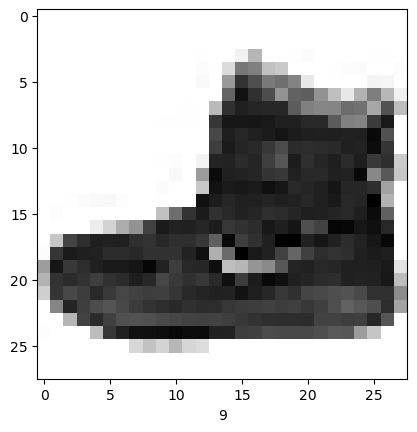

In [11]:
plt.imshow(x_train[0],cmap='binary')
plt.xlabel(y_train[0])
plt.show()

### Creating The Model

In [38]:
def create_model(hyperparameter):
    
    num_hidden_layers = 1
    num_units=8
    dropout_rate=0.1
    learning_rate=0.01
    if hyperparameter:
        num_hidden_layers=hyperparameter.Choice('num_hidden_layers',values=[1,2,3])
        num_units=hyperparameter.Choice('num_units',values=[8,16,32])
        dropout_rate=hyperparameter.Float('dropout_rate',min_value=0.1,max_value=0.5)
        learning_rate=hyperparameter.Float('learning_rate',min_value=0.0001,max_value=0.01)
    model=tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    model.add(tf.keras.layers.Lambda(lambda x : x/255.))
    for _ in range(0,num_hidden_layers):
        model.add(tf.keras.layers.Dense(num_units,activation='relu'))
        model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(10,activation='softmax'))
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer= tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model 


In [39]:
create_model(None).summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 lambda_1 (Lambda)           (None, 784)               0         
                                                                 
 dense_3 (Dense)             (None, 8)                 6280      
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_4 (Dense)             (None, 10)                90        
                                                                 
Total params: 6370 (24.88 KB)
Trainable params: 6370 (24.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [45]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
    def run_trial(self,trial,*args,**kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size',32,128,step=32)
        return super(CustomTuner,self).run_trial(trial,*args,**kwargs) 

In [46]:
tunner = CustomTuner(
    create_model,
    objective='val_accuracy',
    max_trials=20,
    directory='logs',
    project_name='fashion_mnist',
    overwrite=True
)

In [47]:
tunner.search_space_summary()

Search space summary
Default search space size: 4
num_hidden_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
num_units (Choice)
{'default': 8, 'conditions': [], 'values': [8, 16, 32], 'ordered': True}
dropout_rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.5, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'linear'}


### HyperParameters Tuning Experiment

In [48]:
tunner.search(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=5,
    verbose=False
)

INFO:tensorflow:Oracle triggered exit


In [49]:
tunner.results_summary(1)

Results summary
Results in logs\fashion_mnist
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 17 summary
Hyperparameters:
num_hidden_layers: 1
num_units: 32
dropout_rate: 0.1
learning_rate: 0.0001
batch_size: 32
Score: 0.8364999890327454


### Training Model with tuned hyperparameters

In [50]:
model=tunner.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 lambda (Lambda)             (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 25450 (99.41 KB)
Trainable params: 25450 (99.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [51]:
_=model.fit(
    x_train,y_train,
    validation_data=(x_test,y_test),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)]
)

Epoch 1/20
1875/1875 [==============================] - 7s 3ms/step - loss: 0.4754 - accuracy: 0.8367 - val_loss: 0.4628 - val_accuracy: 0.8372
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4598 - accuracy: 0.8410 - val_loss: 0.4523 - val_accuracy: 0.8411
Epoch 3/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4450 - accuracy: 0.8461 - val_loss: 0.4420 - val_accuracy: 0.8446
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4320 - accuracy: 0.8505 - val_loss: 0.4328 - val_accuracy: 0.8494
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4252 - accuracy: 0.8536 - val_loss: 0.4277 - val_accuracy: 0.8484
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4170 - accuracy: 0.8563 - val_loss: 0.4230 - val_accuracy: 0.8519
Epoch 7/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4117 - accuracy: 0.8569 - val_loss: 0.4171 - val_accuracy: